In [1]:
import sys
import os

package_path: str = '../..'
if package_path not in sys.path:
    sys.path.append(package_path)

%reload_ext autoreload
%autoreload 2

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.typing as npt
from scipy.signal import find_peaks, savgol_filter
from scipy.ndimage import center_of_mass
from roi_rectangle import RoiRectangle

from src.analyzer.converter import load_npz
from src.filesystem import get_run_scan_directory
from src.config.config import load_config, ExpConfig


config: ExpConfig = load_config(reload=True)
config.path

ExpPaths(log_dir='./logs', load_dir='E:\\XFEL\\sample_data', analysis_dir='E:\\XFEL\\sample_data', mat_dir='E:\\XFEL\\sample_data\\mat_files', processed_dir='E:\\XFEL\\sample_data\\processed_data', output_dir='E:\\XFEL\\sample_data\\output_data')

In [12]:
run_n: int = 144
npz_dir: str = get_run_scan_directory(config.path.processed_dir, run_n, 1)
npz_file: str = os.path.join(npz_dir, f"run={run_n:0>4}_scan=0001.npz")

_data: dict[str: npt.NDArray] = load_npz(npz_file)
delays: npt.NDArray = _data["delay"]
images: npt.NDArray = _data["pon"]

print(f'Load "{npz_file}"')
print(f'{delays.shape = }')
print(f'{images.shape = }')

Load "E:\XFEL\sample_data\processed_data\run=144\scan=001\run=0144_scan=0001.npz"
delays.shape = (137,)
images.shape = (137, 514, 1030)


In [13]:
images = np.maximum(0, images)

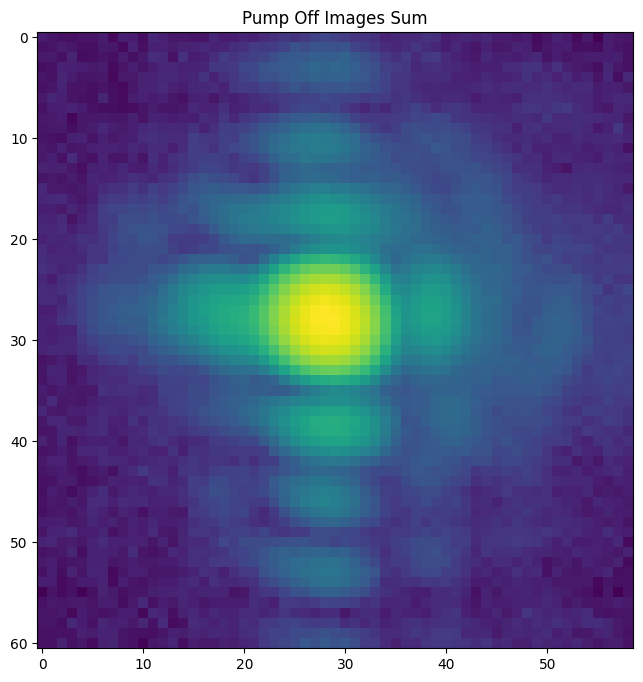

In [14]:
roi_rect: RoiRectangle = RoiRectangle(x1=352, y1=98, x2=411, y2=159)
roi_images: npt.NDArray = roi_rect.slice(images)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(np.log1p(roi_images.sum(0)))
ax.set_title("Pump Off Images Sum")

roi_rect
plt.show()

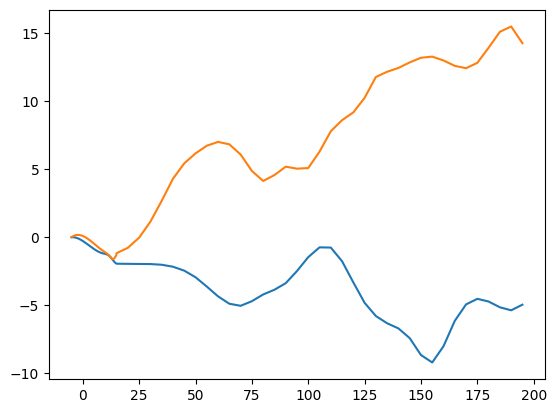

In [17]:
from scipy.ndimage import center_of_mass, gaussian_filter
from scipy.interpolate import UnivariateSpline

def dynamic_roi_tracking(frames, initial_roi: RoiRectangle, smoothing_factor=2):
    centers = []
    roi = initial_roi
    rois = []
    for frame in frames:
        # Apply Gaussian filter to smooth noise
        smoothed_frame = gaussian_filter(frame, sigma=2)

        # Crop ROI dynamically
        roi_frame = roi.slice(smoothed_frame)

        # Calculate center of mass within ROI
        com = center_of_mass(roi_frame)
        global_com = (roi.y1 + com[0], roi.x1 + com[1])
        centers.append(global_com)

        # Update ROI dynamically
        roi = RoiRectangle(
            y1=max(0, int(global_com[0] - 10)),  # Adjust ROI size
            y2=min(frame.shape[0], int(global_com[0] + 10)),
            x1=max(0, int(global_com[1] - 10)),
            x2=min(frame.shape[1], int(global_com[1] + 10)),
        )
        rois.append(roi)
    # Smooth the trajectory
    centers = np.array(centers)
    smoothed_x = UnivariateSpline(range(len(centers)), centers[:, 0], s=smoothing_factor)
    smoothed_y = UnivariateSpline(range(len(centers)), centers[:, 1], s=smoothing_factor)

    return smoothed_x(range(len(centers))), smoothed_y(range(len(centers))), rois

plt.close()
xs, ys, rois = dynamic_roi_tracking(images, roi_rect)
plt.plot(delays, xs - xs[0])
plt.plot(delays, ys - ys[0]);

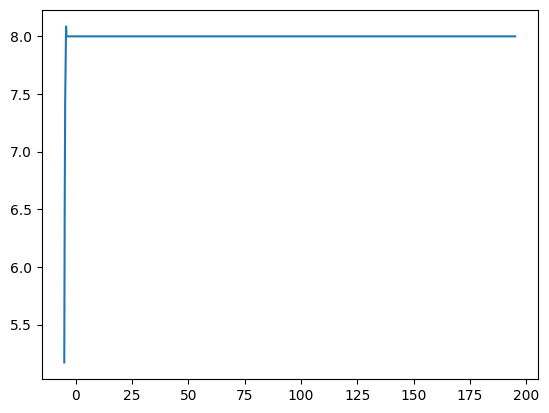

In [9]:
plt.plot(delays, smoothed_peaks)